## Interactive model tester
This allows interactive use of a saved Estimator model against systems configured for the **formal-test-set**.

In [1]:
from pathlib import Path
import re
from textwrap import fill

import numpy as np
import astropy.units as u
from uncertainties import ufloat, UFloat, unumpy

#%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import jktebop, orbital
from ebop_maven import pipeline, plotting
from ebop_maven.estimator import Estimator
import model_testing

from traininglib import formal_testing

### Create our Estimator
Loads the trained machine learning model into an Estimator class. The Estimator makes the model easier to use by handling inputs & outputs, naming features & labels and any scaling of label values.

In [ ]:
# Default option is the model saved and published under ebop_maven/data/estimator
# Then we pick up any models built by make_trained_cnn_model & saved to ./drop/training/**
options = [("estimator/default-model", Path("./ebop_maven/data/estimator/default-model.keras"))] \
    + [(f"{f.parent.name}", f) for f in sorted((Path.cwd() / "drop/training").glob("**/*.keras"))]

model_selection = Dropdown(options=options, value=options[0][1], description="Models: ")
display(model_selection)

Dropdown(description='Models: ', options=(('estimator/default-model', PosixPath('ebop_maven/data/estimator/def…

In [3]:
estimator = Estimator(model=model_selection.get_interact_value())

Estimator loading 'ebop_maven/data/estimator/default-model.keras'...

2024-10-17 15:20:37.178136: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


loaded 'CNN-New-Ext0-bP-4096-None-250k'.
The model CNN-New-Ext0-bP-4096-None-250k was created at 2024-10-17T09:29:35+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


### Target and fitting selection
These targets are taken from the **formal-test-dataset**. These are accompanied with published parameters which we can use to test our results. Targets marked with an asterisk have been excluded from formal testing.

In [4]:
# Our initial target and where to source fitting inputs
default_target = "RR Lyn"
do_control_fit = False

targets_config_file = Path.cwd() / "config" / "formal-test-dataset.json"
targets_cfg = dict(formal_testing.iterate_target_configs(targets_config_file, include_excluded=True))

options = [(f"{t} *" if c.get("exclude", False) else f"{t}", t) for t, c in targets_cfg.items()]
target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=10, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

Read the details of the chosen target, including the labels values. We also
find the size of the required mags feature and any wrapping that needs to be
applied during phase folding by "asking" the estimator.

In [5]:
target = target_selection.get_interact_value()
target_cfg = targets_cfg[target]

print(fill(f"{target}: " + target_cfg.get("desc", ""), 100))
if target_cfg.get("exclude", False):
    print(f"\n\033[93m\033[1m{target} has been excluded from the final cut of the formal-test-dataset.\033[0m")
    print(fill(f"Reason: " + target_cfg.get("why_exclude", ""), 100))

# Get the label values into a structured array [UFloat] form for easy comparison downstream.
label_dict = target_cfg["labels"]
label_dict_keys = [k for k in label_dict if not k.endswith("_err")] # Just the nominals
label_values = np.array([tuple(ufloat(label_dict[k], 0) for k in label_dict_keys)],
                        dtype=[(k, np.dtype(UFloat.dtype)) for k in label_dict_keys])

RR Lyn: An eccentric orbit with eclipses of approximately 0.35 and 0.25 mag and the secondary near
phase 0.45. Evidence of delta-Scuti & gamma-Dor pulsations. Our labels are taken from the solution
with third light.


### Ingest the lightcurves
Searches for the target in the MAST archive and downloads timeseries fits files. Subsequent calls may be serviced from a local cache.

For each lightcurve we perform the following initial ingest actions:
- mask out rows where the quality column matches the quality_bitmask from the target's config
- optionally mask out any distorted regions indicated by quality_mask (from, to) time ranges in the target's config
- optionally bin the lightcurve as indicated by any bin_time item in the target's config
- generate delta_mag and delta_mag_err differential magnitude columns
- de-trend the lightcurve by fitting and subtracting a low-order polyomial
- create a phase-folded copy of the lightcurve, about the primary_epoch and period from the target's config

Once we have the phase-folded lightcurves we can fit an interpolated model to it
with the number of bins matching the input requirement of the Estimator's mag feature.
Alongside this we gather any further simple feature values the Estimator will require.

In [6]:
# Download, load and pre-process the target's lightcurve data
# which will be read, rectified & extended with delta_mag and delta_mag_err cols
(lc, sector_count) = formal_testing.prepare_lightcurve_for_target(target, target_cfg)

# The ephemeris config data are mandatory, so error if missing
period = target_cfg["period"] * u.d
pe = pipeline.to_lc_time(target_cfg["primary_epoch"], lc)

# Work out how we will position/wrap the phase folded mags feature
mags_bins = estimator.mags_feature_bins
wrap_phase = estimator.mags_feature_wrap_phase
if wrap_phase is None:
    wrap_phase = 0.5 + (orbital.secondary_eclipse_phase(label_dict.get("ecosw", 0), target_cfg.get("ecc", 0)) / 2)
    print(f"\nThe mags feature to be centred on the mid-point between eclipses by wrapping above phase {wrap_phase:.3f}")
else:
    print(f"\nThe mags feature to be wrapped above phase {wrap_phase:.3f}")

# Get the phase folded and binned mags feature
print(f"\nCreating folded and phase normalized lightcurves about", f"{pe.format} {pe} & {period}.")
fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
phases, mags = pipeline.get_sampled_phase_mags_data(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)

Searching for lightcurves based on; search term=RR Lyn, sectors=[20], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/rr_lyn
Found 1 existing fits matching mission and author criteria
Found the required 1 fits file(s) meeting the TIC, sector & exptime criteria. Will load the requested lightcurves from these.
Opened light-curve fits for TIC 11491822 sector 20
NaN/negative flux masks match 0 row(s).
Creating a flatten transit mask from 2 transit time range(s) and the orbital period of 9.945126564 d.
Flattening the Light-curve
Will detrend (and rectify by subracting trends) over the following range [btjd]: 1842.508654-1868.826252
	Generated polynomial; y = poly(x, c0=5.626174e-04, c1=1.069227e-05) (sigma(fit_ydata)=8.363236e-05 mag)

The mags feature to be centred on the mid-point between eclipses by wrapping above phase 0.725

Creating folded and phase normalized lightcurves about btjd 1851.926234608 & 

### Plot the target light-curve alongside the phase folded model
Make a plot of the ingested lightcurve with the position of the primary epoch
highlighted and the phase-folded lightcurve overlaid with the interpolated mags
feature which will be used as an input to the Estimator.

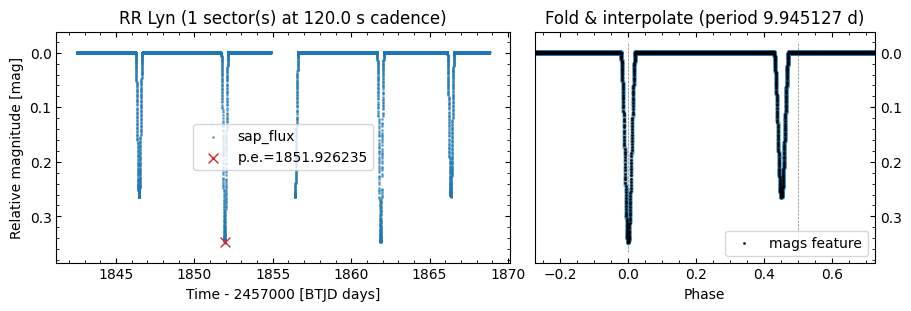

In [7]:
target_label = target_cfg.get("label", target)
exptime = lc.meta["FRAMETIM"] * lc.meta["NUM_FRM"] * u.s  

fig = plt.figure(figsize=(9, 3), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=1, width_ratios=(4, 3))
ax_lc = fig.add_subplot(gs[0, 0])
plotting.plot_lightcurve_on_axes(ax_lc, lc, "delta_mag", lc.meta["FLUX_ORIGIN"],
                                 primary_epoch=pe, primary_epoch_label=f"p.e.={pe.value:.6f}",
                                 ylabel="Relative magnitude [mag]", legend_loc="best", inverty=True,
                                 title=f"{target_label} ({sector_count} sector(s) at {exptime} cadence)")

ax_fld = fig.add_subplot(gs[0, 1], sharey=ax_lc)
plotting.plot_folded_lightcurve_on_axes(ax_fld, fold_lc, "delta_mag", None, show_phase_vlines=True,
                                        overlay_data=(phases, mags), overlay_data_label="mags feature",
                                        ylabel="", yticklabel_right=True, inverty=False,
                                        xlim=(min(phases), max(phases)), legend_loc="best",
                                        title=f"Fold & interpolate (period {period:.6f})")

plt.show()

### Estimate the JKTEBOP fitting parameters
This is where the magic happens!

Estimator is used to directly predict the values of the $r_A+r_B$, $k$, $J$,
$e\cos{\omega}$, $e\sin{\omega}$ and $b_P$ parameters, with the orbital inclination
($i$) derived from these, for use as input values of subsequent fitting with JKTEBOP.

If iterations >1 then the MC Dropout algorithm will be used which repeats the
requested predictions the given number of times with Dropout enabled. Dropout
randomly drops a proportion of the neurons in the full neural network, so in
this configuration each iteration will give a prediction from a different subset
of the full network.

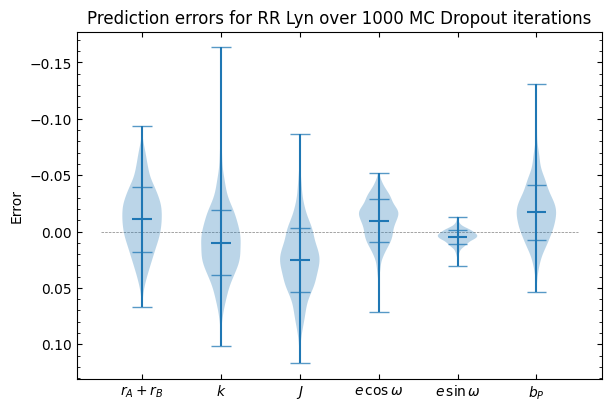

In [8]:
# The model predicts scaled values (e.g. inc*0.01) which the Estimator unscales. An  iterations > 1
# triggers the MC Dropout algorithm, where the predictions are mean & stddev of multiple predictions
# available, when include_raw_preds=True, as an ndarray[float] shape(#insts, #labels, #iterations).
# Here we use 1000 MC Dropout iterations unless it's control fit, where the predictions are ignored.
iterations = 1 if do_control_fit else 1000
predictions, raw_preds = estimator.predict(np.array([mags]), None, iterations, include_raw_preds=True)

if iterations > 1:
    # Plot the errors (label-pred) for each MC iteration in a violin plot to show the distributions
    label_noms = unumpy.nominal_values(label_values[estimator.label_names].tolist())
    raw_errors = label_noms.transpose() - raw_preds
    fig, axes = plt.subplots(figsize=(6, 4), constrained_layout=True)
    plotting.plot_prediction_distributions_on_axes(axes, raw_errors, estimator.label_names,
                                violin_plot=True, show_1sigma_lines=True, ylabel="Error", inverty=True,
                                title=f"Prediction errors for {target_label} over {iterations} MC Dropout iterations")
    plt.show()

The final output predictions will be the mean and 1-sigma values calculated
from the set of predictions from every iteration. The table shows the
predictions (nominals) against the (published) label values along with the
residual, MAE and MSE loss metrics.

In [9]:
# Handle the estimator predicting bP rather than inc directly; JKTEBOP uses inc
predicted_labels = list(predictions.dtype.names)
if "inc" not in predicted_labels and "bP" in predicted_labels:
    print(f"{estimator.name} doesn't predict inc so it will be calculated from other predictions")
    predictions = model_testing.append_calculated_inc_predictions(predictions)
    predicted_labels += ["inc"]

# Produce some statistics on the quality of the predictions.
print(f"\nThe Estimator's predictions over {iterations} iteration(s) for {target}")
model_testing.predictions_vs_labels_to_table(predictions, label_values, target, predicted_labels)

if do_control_fit:
    print("\033[93m\033[1mControl fit requested, so these predictions are not used for fitting.\033[0m")

CNN-New-Ext0-bP-4096-None-250k doesn't predict inc so it will be calculated from other predictions

The Estimator's predictions over 1000 iteration(s) for RR Lyn
---------------------------------------------------------------------------------------------------------------
RR Lyn     | rA_plus_rB          k          J      ecosw      esinw         bP        inc        MAE        MSE
---------------------------------------------------------------------------------------------------------------
Label      |   0.142060   0.629200   0.816000  -0.078061  -0.001600   0.510000  87.460000
Prediction |   0.153185   0.619418   0.790738  -0.068695  -0.006214   0.527289  87.145230
Error      |  -0.011125   0.009782   0.025262  -0.009366   0.004614  -0.017289   0.314770   0.056030   0.014335
---------------------------------------------------------------------------------------------------------------



### Perform JKTEBOP fitting on the target's lightcurves

The estimator will be used to predict the input parameters for fitting with JKTEBOP.
Here we can select the fitting task to conduct;

- Task 3  finds the best fit of the model to observations  (formal errorbars only)
- Task 8  finds robust errors by analysing with a Monte Carlo simulation algorithm
- Task 9  finds robust errors using Monte Carlo given significant correlated noise

If you choose tasks 8 or 9 you will need to specify the number of simulations to run.
Depending on the number of simulations, these tasks will run for significantly longer
than task 3 and their progress will update intermittently.

In [10]:
task = 3                # Set to 3, 8 or 9
simulations = 100       # Ignored for task 3

The parameters estimated above and the ingested lightcurves are now used to generate
an equivalent pair of in & dat files for the target. JKTEBOP is invoked against these
to fit the lightcurve with the EBOP algorithm.

In [11]:
# We have the option of fitting the labels.
# This allows us to test whether a good fit can be achieved with appropriate inputs.
if do_control_fit:
    print("\033[93m\033[1mControl fit requested, so labels are used for fitting input parameters\033[0m\n")
    input_params = label_values[predicted_labels].copy()
else:
    input_params = predictions.copy()

file_stem = f"int-tester-" + re.sub(r"[^\w\d-]", "-", target.lower())
read_params = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "bP", "ecc", "omega", "phiS", "rA", "rB"]

# Generate the input files then perform the task3 fit taking the preds or control as input params
# and supplementing them with parameter values and fitting instructions from the target's config.
fitted_vals = model_testing.fit_target(lc, target, input_params, target_cfg, read_params, file_stem, task, simulations)


Fitting RR Lyn (with 1 sector(s) of data) with JKTEBOP task 3...
  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  int-tester-rr-lyn.par                             
>> Opened new LC output  file:  int-tester-rr-lyn.out                             
>> Opened new model fit  file:  int-tester-rr-lyn.fit                             
>> Read  17552 datapoints (with errors) from file int-tester-rr-lyn.dat                             
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 60 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:  10.566 
>> Done iteration 2 to adjust errorbars. Chisqred values:  

### Review the JKTEBOP fitting results
For each fitted target, JKTEBOP produces parameter (par), model (fit) and
task output (out) files. For task 3 the out file contains a phase folded
copy of the fitted lightcurve and the residuals, which we plot below. When
running tasks 8 or 9, the out file contains simulation data so this plot is
not produced.

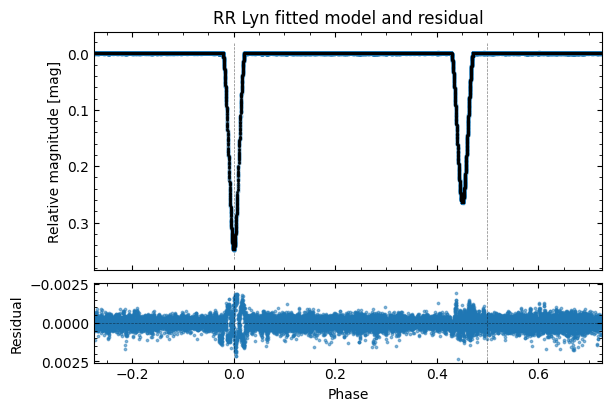

In [12]:
if task == 3:
    # Read the fit data from the out file, and roll the phases to match that used in estimations
    with open(jktebop.get_jktebop_dir() /f"{file_stem}.out", mode="r", encoding="utf8") as ff:
        fit_data =  np.loadtxt(ff, usecols=[3, 4, 5], comments="#", dtype=np.double, unpack=True)
        fit_data[0][fit_data[0] > np.max(fold_lc.time).value] -= 1.

    # A grid of two stacked Axes. Upper for the folded lc & model and lower for the residuals
    fig = plt.figure(figsize=(6, 4), constrained_layout=True)
    gs = GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=(3, 1))
    ax_fld = fig.add_subplot(gs[0, 0])

    plotting.plot_folded_lightcurve_on_axes(ax_fld, fold_lc, "delta_mag", show_phase_vlines=True,
                                            overlay_data=fit_data, overlay_data_label=None,
                                            xlabel="", ylabel="Relative magnitude [mag]", inverty=True,
                                            title=f"{target_label} fitted model and residual")
    plt.setp(ax_fld.get_xticklabels(), visible=False) # Hides xtick labels on this part shared axes

    ax_res = fig.add_subplot(gs[1, 0], sharex=ax_fld)
    ax_res.scatter(x=fit_data[0], y=fit_data[2], s=3, alpha=.5)
    abs_max_ylim = max(np.abs(ax_res.get_ylim()))
    plotting.format_axes(ax_res, title="", xlabel="Phase", ylabel="Residual",
                        xlim=(min(phases), max(phases)), ylim=(abs_max_ylim, -abs_max_ylim))
    (ymin, ymax) = ax_res.get_ylim()
    ax_res.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
    ax_res.hlines([0.0], min(phases), max(phases), linestyles="--", color="k", lw=.5, alpha=.5)
    plt.show()

In [13]:
print(f"{target} JKTEBOP fitted parameters with formal errorbars (where given)")
for param in fitted_vals.dtype.names:
    print(f"{param:>12s}: {fitted_vals[param]:11.6f}")

RR Lyn JKTEBOP fitted parameters with formal errorbars (where given)
  rA_plus_rB:    0.141895+/-   0.000128
           k:    0.627883+/-   0.000991
           J:    0.814161+/-   0.003752
       ecosw:   -0.078071+/-   0.000003
       esinw:    0.000874+/-   0.000420
         inc:   87.485874+/-   0.020946
          L3:    0.038224+/-   0.003059
          pe: 1851.926273+/-   0.000011
      period:    9.945035+/-   0.000009
          bP:    0.499742+/-          0
         ecc:    0.078076+/-          0
       omega:  179.358780+/-          0
        phiS:    0.450349+/-          0
          rA:    0.087165+/-          0
          rB:    0.054730+/-          0


In [14]:
print(f"The JKTEBOP model's fitted parameters vs the label values for {target}")
fitted_labels = ["inc" if n == "bP" else n for n in estimator.label_names]
model_testing.predictions_vs_labels_to_table(fitted_vals, label_values, target,
                                             fitted_labels, prediction_head="Fitted")

The JKTEBOP model's fitted parameters vs the label values for RR Lyn
----------------------------------------------------------------------------------------------------
RR Lyn     | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
----------------------------------------------------------------------------------------------------
Label      |   0.142060   0.629200   0.816000  -0.078061  -0.001600  87.460000
Fitted     |   0.141895   0.627883   0.814161  -0.078071   0.000874  87.485874
Error      |   0.000165   0.001317   0.001839   0.000010  -0.002474  -0.025874   0.005280   0.000113
----------------------------------------------------------------------------------------------------

